In [1]:
!pip install natsort

In [3]:
import glob
from natsort import natsorted

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from leopard_em.analysis.zscore_metric import gaussian_noise_zscore_cutoff

In [4]:
plt.rcParams.update(
    {
        "font.size": 7,
        "axes.labelsize": 7,
        "axes.titlesize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.edgecolor": (0, 0, 0, 0.6),
        "xtick.color": (0, 0, 0, 0.6),
        "ytick.color": (0, 0, 0, 0.6),
        "axes.labelcolor": (0, 0, 0, 0.6),
    }
)

## Constants used throughout notebook

In [5]:
MATCH_TEMPLATE_DIR_REFERENCE = "/data/papers/Leopard-EM_paper_data/xe30kv/results_refine_tm_60S_noB"
MATCH_TEMPLATE_DIR_CONSTRAINED = "/data/papers/Leopard-EM_paper_data/xe30kv/results_match_tm_40S-body_noB"
CONSTRAINED_SEARCH_DIR = "/data/papers/Leopard-EM_paper_data/xe30kv/results_all_steps_noB_2/final_results/"
OUTPUT_DIR = "/data/papers/Leopard-EM_paper_data/xe30kv/results_all_steps_noB_2/final_results/"

## Collecting results into unified DataFrame

In [6]:
# All results CSV files from the reference match template directory
refined_results_reference = glob.glob(f"{MATCH_TEMPLATE_DIR_REFERENCE}/*refined_results.csv")
refined_results_reference_sorted = natsorted(refined_results_reference)

# All results CSV files from the constrained particle match template directory
refined_results_constrained = glob.glob(f"{MATCH_TEMPLATE_DIR_CONSTRAINED}/*_results.csv")
refined_results_constrained_sorted = natsorted(refined_results_constrained)

# All results CSV files from the constrained search directory
constrained_results = glob.glob(f"{CONSTRAINED_SEARCH_DIR}/*results_above_threshold.csv")
constrained_results_sorted = natsorted(constrained_results)

In [7]:
exclude_filters = [
    "245",
    "249",
    "254",
    "255",
    "264",
    "265",
    "266",
    "267",
    "268",
    "270",
    "271",
    "285",
    "286",
    "289",
    "290",
]

# Filter the 2dtm results
refined_results_reference_filtered = [f for f in refined_results_reference_sorted if not any(exclude in f for exclude in exclude_filters)]
refined_results_constrained_filtered = [f for f in refined_results_constrained_sorted if not any(exclude in f for exclude in exclude_filters)]
constrained_results_filtered = [f for f in constrained_results_sorted if not any(exclude in f for exclude in exclude_filters)]

In [8]:
def collect_results_files(
    reference_match_template_files: list[str],
    constrained_match_template_files: list[str],
    constrained_search_files: list[str],
) -> list[tuple[str, str, str]]:
    """Collect the files from the same original dataset together based on name."""
    # NOTE: This assumes naming schemes and file structure are consistent.
    collected_results = []
    result_counts = 0

    # Look for matches based on the reference match template files
    for ref_mt in reference_match_template_files:
        base_name = ref_mt.split("/")[-1].replace("_refined_results.csv", "")

        # Find constrained files which also contain this string
        const_mt = [c for c in constrained_match_template_files if base_name in c]
        const_search = [c for c in constrained_search_files if base_name in c]

        # Check that there is exactly one match for each

        if len(const_mt) == 1 and len(const_search) == 1:
            result_counts += 1
            collected_results.append((ref_mt, const_mt[0], const_search[0]))

    return collected_results, result_counts


collected_results, result_counts = collect_results_files(
    refined_results_reference_filtered,
    refined_results_constrained_filtered,
    constrained_results_filtered,
)
print(f"Found {result_counts} results")

Found 51 results


In [9]:
def process_all_results(collected_results: list[tuple[str, str, str]]) -> None:
    """Process all collected results and save the processed data."""
    df_reference = pd.DataFrame()
    df_constrained_mt = pd.DataFrame()
    df_constrained_search = pd.DataFrame()

    for ref_file, const_mt_file, const_search_file in collected_results:
        # Read the CSV files
        df_ref = pd.read_csv(ref_file)
        df_const_mt = pd.read_csv(const_mt_file)
        df_const_search = pd.read_csv(const_search_file)

        # Append to the main dataframes
        df_reference = pd.concat([df_reference, df_ref], ignore_index=True)
        df_constrained_mt = pd.concat(
            [df_constrained_mt, df_const_mt], ignore_index=True
        )
        df_constrained_search = pd.concat(
            [df_constrained_search, df_const_search], ignore_index=True
        )
        
    return df_reference, df_constrained_mt, df_constrained_search

df_reference, df_constrained_mt, df_constrained_search = process_all_results(collected_results)

In [10]:
df_reference.head()

,Unnamed: 0,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,...,micrograph_path,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path
0,0,0,14.519789,15.093481,15.555717,15.869745,-0.020482,0.963348,20598240,2176,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
1,1,1,14.865751,14.620520,15.660751,15.485523,0.110778,1.009196,20598240,2389,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
2,2,2,14.814608,14.493384,16.326130,16.105635,0.095645,1.015564,20598240,2743,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
3,3,3,14.770191,14.453476,15.281792,15.096287,0.043479,1.018905,20598240,806,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
4,4,4,14.790621,14.389984,15.668688,15.441456,0.029227,1.025810,20598240,1147,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...


In [11]:
df_constrained_mt.head()

,Unnamed: 0,particle_index,mip,scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,pos_y,pos_x_img,...,micrograph_path,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path
0,0,0,9.676947,9.396828,0.174896,1.011198,20598240,1177,1674,1433,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/SSU-b...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
1,1,1,9.279869,8.941745,0.069803,1.030008,20598240,3205,982,3461,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/SSU-b...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
2,2,2,8.979637,8.863303,0.069376,1.005298,20598240,2403,1847,2659,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/SSU-b...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
3,3,3,8.896357,8.806473,0.077818,1.001370,20598240,2756,1798,3012,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/SSU-b...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...
4,4,4,9.310955,8.805031,0.081443,1.048209,20598240,3326,493,3582,...,/data/papers/Leopard-EM_paper_data/xe30kv/all_...,/data/papers/Leopard-EM_paper_data/maps2/SSU-b...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...


In [12]:
df_constrained_search.head()

,Unnamed: 0,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,...,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path,step
0,0,0,14.519789,15.093481,9.330803,9.547881,-0.020482,0.963348,20598240,2176,...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,4
1,1,1,14.865751,14.620520,6.064057,5.921460,0.110778,1.009196,20598240,2389,...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,4
2,2,2,14.814608,14.493384,6.542275,6.330661,0.095645,1.015564,20598240,2743,...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,4
3,5,5,14.588776,14.334961,6.701483,6.717777,0.180617,1.005106,20598240,1428,...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,4
4,6,6,14.725212,14.264278,7.715645,7.463552,0.087231,1.026199,20598240,2859,...,/data/papers/Leopard-EM_paper_data/maps2/60S_m...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,/data/papers/Leopard-EM_paper_data/xe30kv/resu...,4


In [13]:
df_constrained_search["original_offset_psi"]

0        1.0
1       -7.8
2       -4.5
3       -6.7
4      -10.8
        ... 
7462     0.0
7463    -2.2
7464     0.0
7465    -1.0
7466    -3.0
Name: original_offset_psi, Length: 7467, dtype: float64

## Plotting counts bar chart

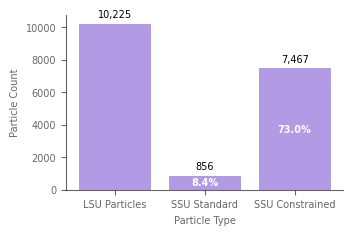

Summary:
Total 60S particles: 10,225
Total 40S particles (standard): 856
Total 40S particles (constrained): 7,467
Fraction 40S found (standard): 0.0837 (8.37%)
Fraction 40S found (constrained): 0.7303 (73.03%)


In [14]:
# Calculate particle counts
count_reference = len(df_reference)
count_constrained_mt = len(df_constrained_mt)  
count_constrained_search = len(df_constrained_search)

# Calculate fractions relative to reference particles
fraction_constrained_mt = count_constrained_mt / count_reference
fraction_constrained_search = count_constrained_search / count_reference

# Create bar chart
fig, ax = plt.subplots(figsize=(90/25.4, 60/25.4))

categories = ['LSU Particles', 'SSU Standard', 'SSU Constrained']
counts = [count_reference, count_constrained_mt, count_constrained_search]

bars = ax.bar(categories, counts, color='#9370DB', alpha=0.7)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height):,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=7)

# Add percentage labels for 40S bars
ax.annotate(f"{fraction_constrained_mt*100:.1f}%",
           xy=(1, count_constrained_mt / 2),
           ha='center', va='center',
           color='white', fontsize=7, weight='bold')

ax.annotate(f"{fraction_constrained_search*100:.1f}%",
           xy=(2, count_constrained_search / 2),
           ha='center', va='center',
           color='white', fontsize=7, weight='bold')

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.6)
ax.spines['bottom'].set_alpha(0.6)
ax.grid(False)

ax.set_xlabel('Particle Type', fontsize=7)
ax.set_ylabel('Particle Count', fontsize=7)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_particle_counts.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_particle_counts.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print(f"Summary:")
print(f"Total 60S particles: {count_reference:,}")
print(f"Total 40S particles (standard): {count_constrained_mt:,}")
print(f"Total 40S particles (constrained): {count_constrained_search:,}")
print(f"Fraction 40S found (standard): {fraction_constrained_mt:.4f} ({fraction_constrained_mt*100:.2f}%)")
print(f"Fraction 40S found (constrained): {fraction_constrained_search:.4f} ({fraction_constrained_search*100:.2f}%)")

## 1D histogram plots for Theta and Psi offsets

In [15]:
bins = np.arange(-15.5, 5.5, 1)
bins

array([-15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,
        -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,
         2.5,   3.5,   4.5])

In [16]:
90/25.4, 60/25.4

(3.5433070866141736, 2.362204724409449)

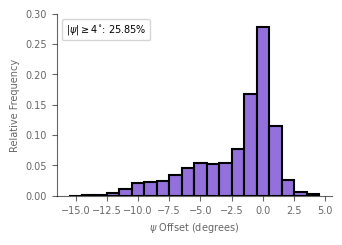

In [17]:
# pct_psi_ge_4 = (
#     np.sqrt(
#         df_constrained_search["original_offset_psi"] ** 2
#         + df_constrained_search["original_offset_theta"] ** 2
#     )
#     >= 4
# )
pct_psi_ge_4 = df_constrained_search["original_offset_psi"].abs() >= 4
pct_psi_ge_4 = pct_psi_ge_4.mean() * 100

fig, ax = plt.subplots(figsize=(90 / 25.4, 60 / 25.4))

plt.hist(
    df_constrained_search["original_offset_psi"],
    bins=bins,
    density=True,
    color="#9370DB",
    edgecolor="black",
    linewidth=1.5,
)
plt.plot(
    [], [], " ", label=rf"$\vert \psi \vert \geq 4^{{\circ}}$: {pct_psi_ge_4:.2f}%"
)
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel("Relative Frequency")
plt.ylim(0, 0.30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend(handlelength=0, handletextpad=0, loc="upper left")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_phi_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_phi_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()

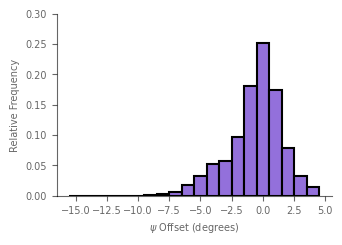

In [18]:
fig, ax = plt.subplots(figsize=(90 / 25.4, 60 / 25.4))

plt.hist(
    df_constrained_search["original_offset_theta"],
    bins=bins,
    density=True,
    color="#9370DB",
    edgecolor="black",
    linewidth=1.5,
)
# plt.plot(
#     [], [], " ", label=rf"$\vert \psi \vert \geq 4^{{\circ}}$: {pct_psi_ge_4:.2f}%"
# )
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel("Relative Frequency")
plt.ylim(0, 0.30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.legend(handlelength=0, handletextpad=0, loc="upper left")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_theta_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_theta_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()

## Contour plot for 2D angular distributions

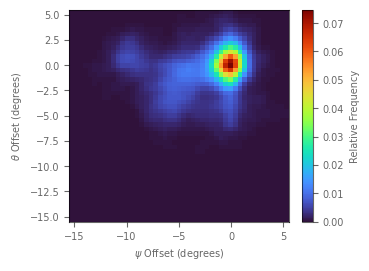

In [19]:
phi_bins = np.linspace(-15.5, 5.5, num=48)
theta_bins = np.linspace(-15.5, 5.5, num=48)

phi_edges = phi_bins[:-1] + phi_bins[1:] / 2
theta_edges = theta_bins[:-1] + theta_bins[1:] / 2
xx, yy = np.meshgrid(phi_edges, theta_edges)

# 2D histogram for psi and theta offsets onto the grid
hist, xedges, yedges = np.histogram2d(
    df_constrained_search["original_offset_psi"],
    df_constrained_search["original_offset_theta"],
    bins=[phi_bins, theta_bins],
    density=True,
)

# Apply Gaussian smoothing to the histogram
hist = gaussian_filter(hist, sigma=1)

# Create a heatmap of the density
fig, ax = plt.subplots(figsize=(90 / 25.4, 70 / 25.4))

im = ax.imshow(
    hist.T,
    cmap="turbo",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin="lower",
    aspect="auto",
    # interpolation="bilinear",
)
cbar = plt.colorbar(im, ax=ax)


cbar.set_label("Relative Frequency")
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel(r"$\theta$ Offset (degrees)")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_2d_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_2d_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()